In [11]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

RANDOM_STATE = 42

## Load Data

In [12]:
# Resolve project paths and organize outputs
PROJECT_ROOT = Path.cwd()
if not (PROJECT_ROOT / "datasets").exists() and (PROJECT_ROOT.parent / "datasets").exists():
    PROJECT_ROOT = PROJECT_ROOT.parent
if not (PROJECT_ROOT / "datasets").exists():
    raise FileNotFoundError("Could not locate datasets folder. Run from project root or src directory.")

DATA_DIR = PROJECT_ROOT / "datasets" / "boston-housing"
OUTPUT_DIR = PROJECT_ROOT / "outputs"
PLOTS_DIR = OUTPUT_DIR / "plots"
MODELS_DIR = OUTPUT_DIR / "models"
PREDICTIONS_DIR = OUTPUT_DIR / "predictions"
for path in [OUTPUT_DIR, PLOTS_DIR, MODELS_DIR, PREDICTIONS_DIR]:
    path.mkdir(parents=True, exist_ok=True)

print(f"Project root: {PROJECT_ROOT}")
print(f"Outputs directory: {OUTPUT_DIR}")

Project root: /Users/zihanghuang/data-mining
Outputs directory: /Users/zihanghuang/data-mining/outputs


In [13]:
data_path = DATA_DIR / "HousingDataPreprocessed.csv"
df = pd.read_csv(data_path, sep=",")
features_list = list(df.columns)
features_list.remove('MEDV')
X = df[features_list]
y = df['MEDV']

## Train/Test Split

Training set: 303 samples (60%)
Validation set: 101 samples (20%) - for early stopping
Test set: 102 samples (20%)

Train value distribution:


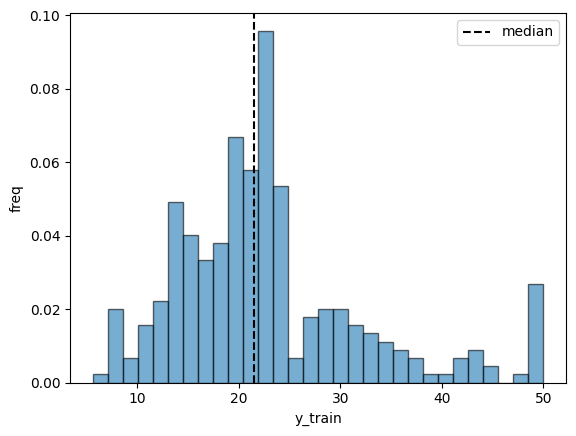

In [14]:
# Stratified train/validation/test split
# First split: train+val vs test (80/20)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=RANDOM_STATE, 
)

# Second split: train vs validation (75/25 of remaining = 60/20 overall)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.25,
    random_state=RANDOM_STATE,
)


print(f"Training set: {X_train.shape[0]:,} samples (60%)")
print(f"Validation set: {X_val.shape[0]:,} samples (20%) - for early stopping")
print(f"Test set: {X_test.shape[0]:,} samples (20%)")
print(f"\nTrain value distribution:")

plt.hist(y_train, bins=30, density=True, alpha=0.6, edgecolor="black")
plt.xlabel("y_train")
plt.ylabel("freq")
plt.axvline(np.median(y_train), linestyle="--", label="median",color="black" )
plt.legend()

## Helper Function

In [15]:
def evaluate_model(model_name, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"\n{'='*50}")
    print(f"{model_name}")
    print(f"{'='*50}")
    print(f"均方误差 (MSE): {mse:.4f}")
    print(f"均方根误差 (RMSE): {rmse:.4f}")
    print(f"平均绝对误差 (MAE): {mae:.4f}")
    print(f"R² 分数: {r2:.4f}")
    
    return {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2}

## Regression Tree

In [16]:
from tqdm import tqdm
import DecisionTree as dt

# find the best model
max_depth_list = [5, 8, 10]
min_sample_list = [2, 5, 8, 10]
loss_list = ["MSE_mean", "MSE_median"]
grid_search_results = []
best_evaluation_loss = float("inf")
best_max_depth = 0
best_min_sample = 0
best_lossfunc = None
best_tree = None

total_combinations = len(max_depth_list) * len(min_sample_list) * len(loss_list)
with tqdm(total=total_combinations, desc="Grid Search", unit="models") as pbar:
    for loss_function_name in loss_list:
        if loss_function_name == "MSE_mean":
            estimator_name = "mean"
        else:
            estimator_name = "median"
        for max_depth in max_depth_list:
            for min_sample in min_sample_list:
                pbar.set_postfix(max_depth=max_depth, min_sample=min_sample, loss=loss_function_name)
                clstree = dt.RegressionTree(
                    loss_function=loss_function_name,
                    leaf_value_estimator=estimator_name,
                    max_depth=max_depth,
                    min_sample=min_sample,
                )
                clstree.fit(X_train, y_train)
                clstree.prune(X_val, y_val)
                y_preds = clstree.predict(X_val)
                current_evaluation_loss = mean_squared_error(y_val, y_preds)

                grid_search_results.append({
                    "loss_function": loss_function_name,
                    "leaf_value_estimator": estimator_name,
                    "max_depth": max_depth,
                    "min_sample": min_sample,
                    "val_mse": current_evaluation_loss,
                })

                if current_evaluation_loss < best_evaluation_loss:
                    best_evaluation_loss = current_evaluation_loss
                    best_max_depth = max_depth
                    best_min_sample = min_sample
                    best_lossfunc = loss_function_name
                    best_tree = clstree
                pbar.update(1)


print(f"Best parameters: max_depth={best_max_depth}, min_sample={best_min_sample}, loss_function = {best_lossfunc}")


Grid Search: 100%|██████████| 24/24 [00:05<00:00,  4.22models/s, loss=MSE_median, max_depth=10, min_sample=10]

Best parameters: max_depth=10, min_sample=2, loss_function = MSE_median


In [17]:
# Evaluate best tree on train and test sets
train_preds = best_tree.predict(X_train)
test_preds = best_tree.predict(X_test)

train_metrics = evaluate_model("RegressionTree (Train)", y_train, train_preds)
test_metrics = evaluate_model("RegressionTree (Test)", y_test, test_preds)



RegressionTree (Train)
均方误差 (MSE): 6.2097
均方根误差 (RMSE): 2.4919
平均绝对误差 (MAE): 1.5188
R² 分数: 0.9307

RegressionTree (Test)
均方误差 (MSE): 21.2351
均方根误差 (RMSE): 4.6082
平均绝对误差 (MAE): 2.9265
R² 分数: 0.7104


In [18]:
# visualize result
tree_model = best_tree.get_stats(X_train.shape[1],X.columns.to_list())
print(f'Total nodes:{tree_model["n_nodes"]}\n')
print(f'Total leaves:{tree_model["n_leaves"]}\n')
print(f'Actual Depth:{tree_model["actual_depth"]}\n')
print(f'Features Counts:\n{tree_model["feature_counts"]}')

Total nodes:103

Total leaves:52

Actual Depth:11

Features Counts:
{'RM': 11, 'NOX': 7, 'B': 5, 'LSTAT': 7, 'AGE': 6, 'CRT_COMBO': 7, 'DIS': 2, 'INDUS': 4, 'CHAS': 1, 'PTRATIO': 1}


## Visualization

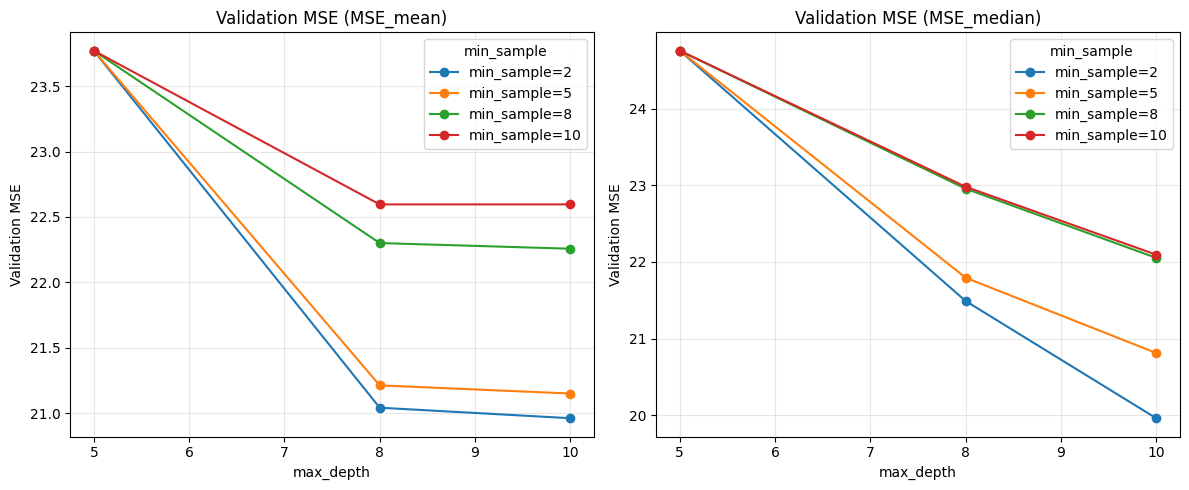

In [19]:
# Visualize validation performance across the grid search
grid_df = pd.DataFrame(grid_search_results)

plt.figure(figsize=(12, 5))
for idx, loss_function_name in enumerate(loss_list, start=1):
    plt.subplot(1, 2, idx)
    subset = grid_df[grid_df["loss_function"] == loss_function_name]
    for min_sample in sorted(subset["min_sample"].unique()):
        sub = subset[subset["min_sample"] == min_sample].sort_values("max_depth")
        plt.plot(sub["max_depth"], sub["val_mse"], marker="o", label=f"min_sample={min_sample}")
    plt.title(f"Validation MSE ({loss_function_name})")
    plt.xlabel("max_depth")
    plt.ylabel("Validation MSE")
    plt.legend(title="min_sample")
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(PLOTS_DIR / "tree_housing_grid_search.png", dpi=150, bbox_inches="tight")
plt.show()


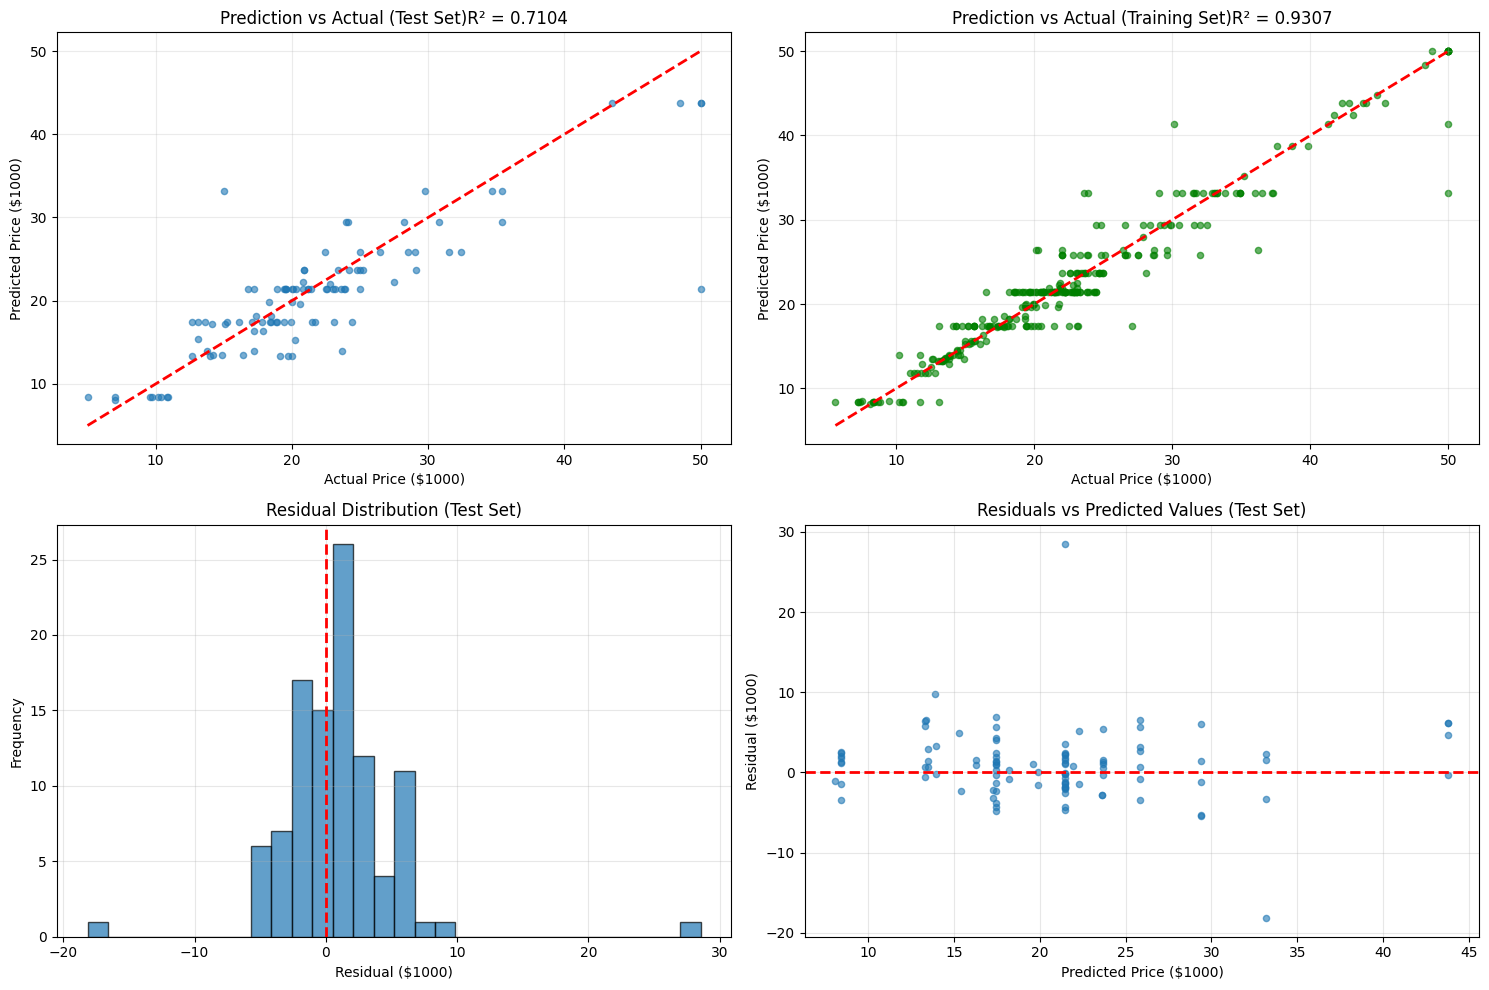

In [21]:
# Prediction and residual diagnostics
plt.figure(figsize=(15, 10))

# 1. Prediction vs Actual Values (Test Set)
plt.subplot(2, 2, 1)
plt.scatter(y_test.values, test_preds, alpha=0.6, s=20)
min_val = min(y_test.min(), test_preds.min())
max_val = max(y_test.max(), test_preds.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
plt.xlabel('Actual Price ($1000)')
plt.ylabel('Predicted Price ($1000)')
plt.title(f'Prediction vs Actual (Test Set)R² = {test_metrics["R2"]:.4f}')
plt.grid(True, alpha=0.25)

# 2. Prediction vs Actual Values (Training Set)
plt.subplot(2, 2, 2)
plt.scatter(y_train.values, train_preds, alpha=0.6, s=20, color='green')
min_val_train = min(y_train.min(), train_preds.min())
max_val_train = max(y_train.max(), train_preds.max())
plt.plot([min_val_train, max_val_train], [min_val_train, max_val_train], 'r--', linewidth=2)
plt.xlabel('Actual Price ($1000)')
plt.ylabel('Predicted Price ($1000)')
plt.title(f'Prediction vs Actual (Training Set)R² = {train_metrics["R2"]:.4f}')
plt.grid(True, alpha=0.25)

# 3. Residual distribution (Test Set)
plt.subplot(2, 2, 3)
residuals = y_test.values - test_preds
plt.hist(residuals, bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Residual ($1000)')
plt.ylabel('Frequency')
plt.title('Residual Distribution (Test Set)')
plt.axvline(x=0, color='r', linestyle='--', linewidth=2)
plt.grid(True, alpha=0.3)

# 4. Residuals vs Predicted
plt.subplot(2, 2, 4)
plt.scatter(test_preds, residuals, alpha=0.6, s=20)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Predicted Price ($1000)')
plt.ylabel('Residual ($1000)')
plt.title('Residuals vs Predicted Values (Test Set)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(PLOTS_DIR / 'tree_housing_results.png', dpi=150, bbox_inches='tight')
plt.show()
